# Lecture 11: Activity Classification Work-Through
In this lecture, we'll work through a real deep learning example from start to finish. This may serve as a useful example to fill in some of the gaps other lectures have. 

Specifically, it is likely that much of the data processing will be surprisingly different from previous lectures. Typically, we've used nice prepackaged datasets, so that the data loading ends up being a single line. Here, however, we start with unlabeled video, go through how to create labels, and package it all up for MXNet.

We also explore another application of RNNs and find that they are surprisingly effective!

## Problem Description
The task we're going to attempt to solve in this lecture is __SmartWatch Based Activity Classification__.

A brief description of the task is that a user has a wrist mounted smartwatch with a camera. As the user goes about their day, the smartwatch gets images and attempts to determine what the user is doing. This could have a myriad of potential applications such as producitivy assessment, elder care, efficient government spying, context-aware applications, and more!

The requirements of this project aren't super strict, it's ok if we occasionally misclassify an activity. That said, to create a compelling experience, we'd like above 80% accuracy.

To start off, we want to think about what our data should look like. In this case, we need a user to perform activities while wearing a wrist mounted camera. We have a go-pro with a strap, so the wrist mounted camera can be checked off the list. Next, we need to determine what type of activities should be classified. 

This has a few different considerations. Of course, we'd like as many different activities to work as possible. But, we have limited time and are interested in a proof of concept at this stage. Let's limit the number of classes to 5.

Given that we are going to have 5 output classes, we don't want to waste them on things that are redundant or unnecessarily difficult. Of course, we want a class for doing nothing which we hope will catch all actions that aren't one of our other 4. For now, we choose to pick the other 4 to be common household activities. We pick tasks that __visually distinguishable__ by a human but not so different as to be meaningless.

* Nothing: the default class
* Book Reading: reading a book has clear visual cues that are noticeable at the wrist, it's a good place to start.
* Watching TV: Similar environment to book reading (living room) but different focus. This is a viable class without being over simple.
* Cleaning: Task with high movement, should be a good simulation of other movement based tasked.
* Getting dressed: Task that has obstruction of wrist, important that our network can identify these cases.

Now, we have what we need to define a simple input output relationship. Our input is an image from a smartwatch, or potentially a sequence of images, and our output is the probability that the image corresponds to each of the 5 classes above.

## Dataset Description
We are clearly interested in a visual dataset, so we shouldn't need anything besides images collected. It's possible adding motion data from something like an accelerometer would improve accuracy but thats a challenge for another day.

We can use a pretrained image classification network, so the learnable portion of our model can be relatively small. This means we don't need a huge amount of data, but the more there is the better! Something like a thousand images should be plenty.

To collect the data, we'll equip a participant with our gopro, and record as they perform a script of activities in their home. Because we're recording video, we'll have a TON of frames to work with. That's great! But it also means a ton of labels.

To perform the labelling, we'll have to watch the video and mark where each different activity starts and stops.

## Model Design
We have a type of task that we haven't really seen before, video processing. Here, each frame is highly related to the adjacent frames, and context has a large influence on the label. This seems like a situation where having memory of previous frames would be really useful! This suggests that an LSTM based model will perform well and benefit from the temporal nature of video.

However, for the LSTM to work, we'll need to feed it well-processed image features. We don't have nearly enough data to train a full stack of convolutional network, so this is a perfect time to take a pretrained network and use it extract features for the LSTM.

Because this is meant to run on a smartwatch, we want to choose a high speed model for our pretrained CNN. We choose MobileNet because its flashy and new.

![mobilenet1](https://raw.githubusercontent.com/joshua19881228/my_blogs/master/Computer_Vision/Reading_Note/figures/Reading_Note_20170719_MobileNet_1.png)
![mobilenet2](https://raw.githubusercontent.com/joshua19881228/my_blogs/master/Computer_Vision/Reading_Note/figures/Reading_Note_20170719_MobileNet_0.png)

After getting the features from MobileNet, we'll feed them into an LSTM layer with 512 neurons. The output of this layer will go to a simple Dense classifier that produces our 5 class guesses.

## Data Processing
Now that we have a plan, let's start by loading up our data and processing it in a way that MXNet can deal with.

In [426]:
# import the usual suspects
import mxnet as mx
import numpy as np
from mxnet import nd, gluon, autograd
import time
ctx = mx.gpu()

# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cv2

In [427]:
# use opencv to read our video from disk
cap = cv2.VideoCapture("/data2/activitydata/GOPR3240.MP4")

In [428]:
# check the number of frames
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
length

32686

In [5]:
# iterate through the frames, resize them, and save them to an array
frames = []
i = 0
# keep going until there are no frames
while(cap.isOpened()):
    # get the next frame
    ret, frame = cap.read()
    # scale it down by a factor of 4 since these images are much bigger than they need to be
    frame = cv2.resize(frame, dsize=(0,0), fx=(1/4), fy=(1/4))
    # add the frame to our dataset
    frames.append(frame)
    #cv2.imshow('frame',gray)
    # print out a status since this takes a while
    i+=1    
    if i%1000==0:
        print(i)
    # check if we're out of images, stop if we are
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
frames = np.asarray(frames)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000


error: /io/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


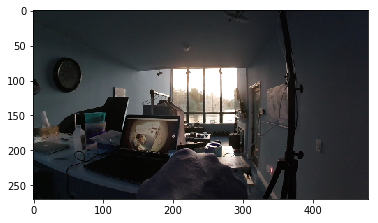

In [6]:
# sample one of our images to make sure it worked
plt.imshow(frames[0])

In [7]:
# convert list to numpy and confirm shape makes sense
train_data = np.asarray(frames)
train_data.shape

(32686, 270, 480, 3)

## Label Generation
Now that we have our data loaded, let's created the matching labels.

Our strategy for this is to use the timestamps we made of where the action transitions occur. By relating those timestamps to a particular frame, we can generate blocks of labels that correspond to the images.

Let's start by making the boundaries in seconds.

In [430]:
# total number of seconds in the video
total_seconds = 9*60+5
# duration each frame represents
seconds_per_frame = total_seconds/train_data.shape[0]

In [438]:
# define the classses
classes = {0:"nothing", 1:"reading", 2:"watching tv", 3:"cleaning", 4:"dressing"}

In [10]:
# compute the label boundaries in terms of seconds
label_boundaries = np.array([0*60+42, 1*60+35, 3*60+38, 3*60+42, 5*60+0, 5*60+20, 6*60+55, 7*60+5, 8*60+45, 9*60+5])

In [11]:
label_boundaries

array([ 42,  95, 218, 222, 300, 320, 415, 425, 525, 545])

In [12]:
# find the frame boundaries
frames_per_label = np.floor(label_boundaries / seconds_per_frame)

In [13]:
frames_per_label

array([ 2518.,  5697., 13074., 13314., 17992., 19191., 24889., 25489.,
       31486., 32686.])

In [14]:
# get the number of frames in each bin
frame_diff = np.zeros(frames_per_label.shape)
frame_diff[0] = frames_per_label[0]
for i in range(len(frames_per_label) -1):
    frame_diff[i+1] = frames_per_label[i+1] - frames_per_label[i]

In [15]:
frame_diff

array([2518., 3179., 7377.,  240., 4678., 1199., 5698.,  600., 5997.,
       1200.])

In [16]:
# label each bin
bin_labels = np.array([0, 1, 2, 0, 3, 0, 4, 0, 1, 0])

In [17]:
# generate the full vector of labels
train_labels = []
# iterate through bins
for i, bin in enumerate(bin_labels):
    # for each frame in that bin, append the label
    for f in range(int(frame_diff[i])):
        train_labels.append(bin)
train_labels = np.array(train_labels)

In [18]:
# confirm shape matches data
train_labels.shape

(32686,)

Great! now we have a training set made up of 31486 datapoints and a corresponding 31486 labels, and we can load that data in batches!

Next, let's work on creating a pretrained network to do our classifications!

In [28]:
# write a little function to get our image in mxnet format
def preprocess(img):
    # convert the image to ndarray
    data = nd.array(img)
    # crop down to 224x224 pixels
    data, _ = mx.image.center_crop(data, (224, 224))
    # add in the batch dimension
    data = data.expand_dims(0)
    # transpose the channels to get format right
    data = data.transpose((0, 3, 1, 2))
    # normalize for pretrained net
    data = mx.image.color_normalize(data/255,
                           mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                           std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
    return data

In [90]:
# also write a few functions to make sure the pretrained model works

import json
class_dict = json.load(open("labels.json"))

# get the output guesses of the network
def predict(net, img):
    img = preprocess(img).as_in_context(ctx)
    output = net(img)
    guesses = nd.topk(output, k=5)[0]
    confidence = nd.softmax(output)[0][guesses]
    return [class_dict[str(int(x))] for x in list(guesses.asnumpy())], confidence

# get the raw features of the network
def get_features(net, img):
    img = preprocess(img).as_in_context(ctx)
    output = net.features(img)
    return output

The last thing we need to do is write a function to grab batches. Because we want to learn sequence information, we'll grab a bunch of adjacent images to feed to our network

In [92]:
# take in the full dataset and labels along with a batch size, produce a random set of batch_size adjacent
# images
def batchify(data, labels, batch_size):
    num_samples = data.shape[0]
    # randomly choose a start index
    batch_start = int(np.ceil(num_samples * np.random.random())) -1
    # handle case where we're at the end of the dataset
    if num_samples - batch_start <= batch_size:
        data, labels = data[batch_start:-1], labels[batch_start:-1]
    else:
        data, labels = data[batch_start:(batch_start+batch_size)], labels[batch_start:(batch_start+batch_size)]
    # get the labels in the right shape
    labels = nd.array(labels).reshape([-1, 1])
    # stick all the batches together
    data = nd.concat(*[preprocess(x) for x in data], dim=0)
    # move to gpu if needed
    return data.as_in_context(ctx), labels.as_in_context(ctx)

## Load a Pretrained Model

In [88]:
# get a pretrained network
from mxnet.gluon.model_zoo import vision as models
# lets use a pretrained squeezenet, this a model known for being decently good accuracy at a low computational cost
net = models.mobilenet1_0(pretrained=True, prefix="act_", ctx=ctx)

Let's make sure our pretrained network can deal with our images. Let's just pass the first image in our dataset through the full network and see if the predictions seem reasonable

In [91]:
predict(net, train_data[0])

(['home theater, home theatre',
  'desk',
  'entertainment center',
  'monitor',
  'television, television system'],
 
 [0.12440012 0.0944401  0.08460987 0.08048154 0.07968535]
 <NDArray 5 @gpu(0)>)

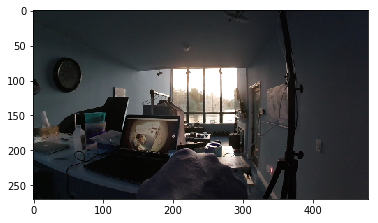

In [54]:
plt.imshow(train_data[0])

In [55]:
# lets also confirm that we can extract just the features of the pretrained model
get_features(net, train_data[0])


[[1.4245358  0.12903129 0.7065095  ... 1.0869589  0.6358901  1.3866035 ]]
<NDArray 1x1024 @cpu(0)>

These seem like reasonable guesses for our image! Great, that means that the pretrained net can probably extract useful information.

## Model Definition

Now, let's define our own layer to replace the output layer of the pretrained model

In [361]:
from mxnet.gluon import rnn
class RNNModel(gluon.Block):
    """A model with an encoder, recurrent layer, and a decoder."""

    def __init__(self, mode, input_size, num_hidden,
                 num_layers, dropout=0.5, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        with self.name_scope():
            # support a few different types of RNN for experimentation
            if mode == 'rnn_relu':
                self.rnn = rnn.RNN(num_hidden, num_layers, activation='relu', dropout=dropout,
                                   input_size=input_size)
            elif mode == 'rnn_tanh':
                self.rnn = rnn.RNN(num_hidden, num_layers, dropout=dropout,
                                   input_size=input_size)
            elif mode == 'lstm':
                self.rnn = rnn.LSTM(num_hidden, num_layers, dropout=dropout,
                                    input_size=input_size)
            elif mode == 'gru':
                self.rnn = rnn.GRU(num_hidden, num_layers, dropout=dropout,
                                   input_size=input_size)
            self.num_hidden = num_hidden
            # add on our classification layer, this takes the output of the RNN and produces labels
            self.dense = gluon.nn.Dense(units=5, in_units=num_hidden)

    def forward(self, inputs, hidden):
        # during forward, change the input to the shape needed by our rnn.
        # the shape expected is TND where T is the sequence length, N is the batch size,
        # and D is the data shape.
        
        # We have kind of a weird system, we've set up our batches to actually be sequences
        # so we'll tell the RNN that we have a sequence of batch_size images, but only one
        # such sequence per batch.
        inputs = inputs.reshape([inputs.shape[0], 1, -1])
        # push the inputs through our rnn
        output, hidden = self.rnn(inputs, hidden)
        # push the rnn features through our classifier
        output = self.dense(output)
        return output, hidden
    # a function to create the state (memories) of our rnn
    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

In [362]:
# when training RNNs, it's sometimes useful to be able to tell the network
# that a new sequence is starting. Detach allows this to happen by preventing
# previous sequences from affecting the gradients.
def detach(hidden):
    if isinstance(hidden, (tuple, list)):
        hidden = [i.detach() for i in hidden]
    else:
        hidden = hidden.detach()
    return hidden

In [363]:
# initialize our model using fairly normal parameters

model = RNNModel(mode='lstm', input_size=1024, num_hidden=512, num_layers=1)
hidden = model.begin_state(func = mx.nd.zeros, batch_size = 1, ctx=ctx)

model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(model.collect_params(), 'sgd',
                        {'learning_rate': 0.01, 'momentum': 0.9, 'wd': 0})
loss = gluon.loss.SoftmaxCrossEntropyLoss()

Make sure data can move through network

In [364]:
# check that we can push data through the RNN
output, hidden = model(get_features(net, train_data[0]), hidden)

In [365]:
output


[[-0.04203233  0.05792284  0.07771613  0.03309473 -0.22246033]]
<NDArray 1x5 @gpu(0)>

In [366]:
# we have an unbalanced dataset, there are more of some labels than others.
# although this may not affect training substantially, it's a good idea
# to weight the more common labels lower than the rare ones to discourage
# the network from overlearning common labels

# first find how often each label appears
_, label_ratios = np.unique(train_labels, return_counts=True)
label_ratios = nd.array(label_ratios).as_in_context(ctx)

# given guess z and label y, compute the loss
def unbalanced_loss(loss_func, z, y):
    # get ratios for each label in y
    y_index = y.reshape([-1])
    # get the ratio for each label in y
    ratios = label_ratios[y_index]
    # discourage common labels
    ratios = 1 - (ratios / len(train_data))
    # compute normal loss
    regular_loss = loss_func(z, y)
    # scale the normal loss
    scaled_loss = regular_loss * ratios
    return scaled_loss

## Training
We're all set up and ready to train! Let's get started

In [367]:
# sometimes during training, it's nice to tweek the optimizer.
# Here's a way of doing that without restarting your network training

#trainer._init_optimizer('sgd',
#    {'learning_rate': .01,
#     'momentum': 0.9,
#     'wd': 0})

In [368]:
# use sequences of 64 images. The sequence length determines how big a window the memory will
# apply to. Here, I'm assuming the 64 previous frames gives enough information to guess the class.
# Maybe it needs more though!
batch_size = 64
def train():
    # keep track of the lowest loss we've seen, useful for saving the model weights
    best_L = float("Inf")
    # Instead of doing epochs, we'll just do steps. Each step looks at one sequence of
    # images. This is similar to doing 2 epochs since 64*500 is close to our image size.
    for step in range(1000):
        # accumulate the loss
        total_L = 0.0        
        # create the memories for our network
        hidden = model.begin_state(func = mx.nd.zeros, batch_size = 1, ctx = ctx)
        # load a batch of data and the corresponding labels
        data, label = batchify(train_data, train_labels, batch_size)
        # make sure the gradients aren't connected to the previous step
        hidden = detach(hidden)
        
        # push the data through our pretrained network
        features = net.features(data)
        
        # since we're now working with our actual model, record the gradients
        with autograd.record():
            # push the features through our RNN
            output, hidden = model(features, hidden)
            # compute the loss
            L = unbalanced_loss(loss, output, label)
        
        # use backward propagation to determine the weight updates
        L.backward()

        # I was trying this thing where I reduced the gradient size of our model,
        # sometimes this helps when things are unstable. It might actually be important
        # for larger batch size, but it didnt seem to help here.
        
        #grads = [i.grad(ctx) for i in model.collect_params().values()]
        # Here gradient is for the whole batch.
        # So we multiply max_norm by batch_size and bptt size to balance it.
        #gluon.utils.clip_global_norm(grads, 0.1)

        # update our weights
        trainer.step(batch_size)
        # accumulate loss for printing
        total_L += mx.nd.sum(L).asscalar()
        
        # every once in a while print out a status
        if step % 10 == 0:
            cur_L = total_L
            print('[Step %d] loss %.2f' % (
                step + 1, cur_L))
            total_L = 0.0

        # if the loss is really good, keep note and maybe save the model or something
        if total_L < best_L:
            best_L = total_L
        #    test_L = eval(test_data)
        #    model.save_params(args_save)
        #    print('test loss %.2f, test perplexity %.2f' % (test_L, math.exp(test_L)))
        #else:
        #    args_lr = args_lr * 0.25
        #    trainer._init_optimizer('sgd',
        #                            {'learning_rate': args_lr,
        #                             'momentum': 0,
        #                             'wd': 0})
        #    model.load_params(args_save, context)

In [369]:
train()

[Step 1] loss 77.03
[Step 11] loss 132.08
[Step 21] loss 54.72
[Step 31] loss 3.98
[Step 41] loss 53.91
[Step 51] loss 22.97
[Step 61] loss 88.08
[Step 71] loss 184.50
[Step 81] loss 5.53
[Step 91] loss 94.42
[Step 101] loss 76.46
[Step 111] loss 58.17
[Step 121] loss 22.84
[Step 131] loss 3.52
[Step 141] loss 0.62
[Step 151] loss 103.33
[Step 161] loss 61.77
[Step 171] loss 384.05
[Step 181] loss 39.60
[Step 191] loss 1.50
[Step 201] loss 18.41
[Step 211] loss 15.07
[Step 221] loss 0.85
[Step 231] loss 0.68
[Step 241] loss 0.26
[Step 251] loss 0.39
[Step 261] loss 3.01
[Step 271] loss 1.84
[Step 281] loss 4.65
[Step 291] loss 2.41
[Step 301] loss 5.35
[Step 311] loss 0.19
[Step 321] loss 1.29
[Step 331] loss 0.26
[Step 341] loss 83.14
[Step 351] loss 20.43
[Step 361] loss 3.43
[Step 371] loss 0.35
[Step 381] loss 120.29
[Step 391] loss 0.95
[Step 401] loss 27.89
[Step 411] loss 67.61
[Step 421] loss 0.13
[Step 431] loss 0.42
[Step 441] loss 4.68
[Step 451] loss 0.85
[Step 461] loss 0.

## Deployment
Now that we have a decently trained model, let's work on getting it to run on video

First, let's just classify a batch of data and make sure our guesses look ok

In [381]:
data, label = batchify(train_data, train_labels, batch_size)

In [443]:
label.transpose()


[[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
  4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
  4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]]
<NDArray 1x64 @gpu(0)>

In [444]:
# push the batch of data through our model

hidden = model.begin_state(func = mx.nd.zeros, batch_size = 1, ctx = ctx)
        
features = net.features(data)
output, hidden = model(features, hidden)
predictions = nd.argmax(output, axis=1)
probs = nd.softmax(output)

In [445]:
predictions


[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
<NDArray 64 @gpu(0)>

Hopefully the predictions match the labels. If so, great! Let's try to process our video frame by frame and check the full accuracy.

Acc: 1.00


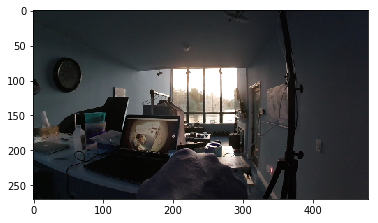

nothing
Acc: 1.00


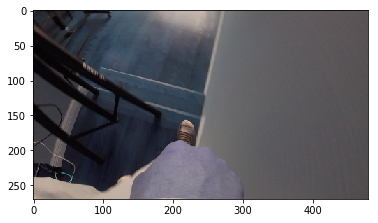

nothing
Acc: 0.96


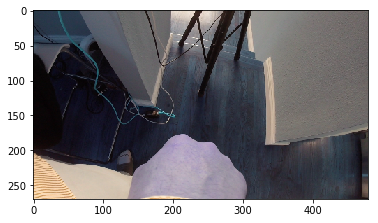

nothing


KeyboardInterrupt: 

In [440]:
# write a function to test a whole video! 
plt.ion()
def evaluate(data, labels, batch_size):
    # keep track of accuracy
    acc = mx.metric.Accuracy()
    # now that we're fully trained, we can let the memory keep updating itself without
    # resetting, basically treating the entire video as one big sequence.
    # to do this, we only reset the hidden state once.
    hidden = model.begin_state(func = mx.nd.zeros, batch_size = 1, ctx = ctx)
    # determine how many batches we need to see the whole video
    num_samples = data.shape[0]
    num_batches = int(num_samples/batch_size)
    # iterate through those batches
    for i in range(num_batches):
        # get the next batch and prepare the data
        draw, y = data[i*batch_size: (i+1)*batch_size], labels[i*batch_size: (i+1)*batch_size]
        x = nd.concat(*[preprocess(n) for n in draw], dim=0)
        y = nd.array(y).reshape([-1,1])
        x = x.as_in_context(ctx)
        y = y.as_in_context(ctx)
        
        # push it through the network
        features = net.features(x)
        output, hidden = model(features, hidden)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=y)
        if i%10 == 0:
            print("Acc: %.2f" % acc.get()[1])
            plt.imshow(draw[0])
            plt.show()
            print(classes[int(predictions[0].asnumpy())])
            #print("Last Class: %d" % y[0].asnumpy())
    return acc.get()[1]

evaluate(train_data, train_labels, 64)

In [441]:
#model.save_params("/data2/activitydata/RNN.params")